In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import PIL

class Caltech256(Dataset):
    '''
    
    Args:
    
        root_dir (string): Location of Caltech256 Dataset,
        images_per_class (int): Number of images to load per class. Class clutter is ignored
        transform (torch.transform): transformation to perform on input image
    
    Example Usage:
    
        example_transform = transforms.Compose(
            [
                transforms.Scale((224,224)),
                transforms.ToTensor(),
            ]
        )

        caltech256_train = Caltech256("/datasets/Caltech256/256_ObjectCategories/", example_transform, train=True)
        
        train_data = DataLoader(
            dataset = caltech256_train,
            batch_size = 32,
            shuffle = True,
            num_workers = 4
        )
        
        
    '''
    def __init__(self, root_dir, transform=None, train = True):
        self.images_per_class = 32 if train else 8
        self.start_image = (~train) * 32
        self.end_image = self.start_image + self.images_per_class
        self.root_dir = root_dir
        self.transform = transform
        self.cats = os.listdir(root_dir)
        self.files = {}
        self.train = train
        for cat in self.cats:
            if "clutter" in cat:
                continue

            currdir = os.path.join(root_dir, cat)
            images = os.listdir(currdir)
            images = filter(lambda s: s.endswith("jpg"), images)
            assert self.images_per_class <= len(images), "Not enough images in class {c}".format(c = currdir)
                
            for i in range(self.start_image, self.end_image):
                self.files[os.path.join(currdir, images[i])] = int("".join(images[i][0:3]))
                 
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img_name, label = list(self.files.items())[idx]
        image = PIL.Image.open(img_name).convert("RGB") # A few images are grayscale
        label = torch.Tensor([label])
        

        if self.transform:
            image = self.transform(image)
        sample = (image, label)
        return sample

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

import torch.optim as optim
import torch.nn as nn

In [3]:
example_transform = transforms.Compose(
            [
                transforms.Scale((224,224)),
                transforms.ToTensor(),
            ]
        )

caltech256_train = Caltech256("/datasets/Caltech256/256_ObjectCategories/", example_transform, train=True)
caltech256_test = Caltech256("/datasets/Caltech256/256_ObjectCategories/", example_transform, train=False)
        
train_data = DataLoader(
            dataset = caltech256_train,
            batch_size = 32,
            shuffle = True,
            num_workers = 4
        )

test_data = DataLoader(
            dataset = caltech256_test,
            batch_size = 32,
            shuffle = True,
            num_workers = 4
        )

In [4]:
def plot_images(images, cls_true, cls_pred=None):

    assert len(images) == len(cls_true) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    for i, ax in enumerate(axes.flat):
        # plot the image
        ax.imshow(images[i, :, :, :], interpolation='spline16')
        
        if cls_pred is None:
            xlabel = "{0}".format(int(Variable(cls_true[i]).data[0]))
        else:
            cls_pred_name = label_names[cls_pred[i]]
            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)
            
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

In [5]:
# This is an example for the CIFAR-10 dataset.
# There's a function for creating a train and validation iterator.
# There's also a function for creating a test iterator.
# Inspired by https://discuss.pytorch.org/t/feedback-on-pytorch-for-kaggle-competitions/2252/4

def get_train_valid_loader(data_dir,
                           batch_size,
                           transform,
                           random_seed=22,
                           valid_size=0.1,
                           shuffle=True,
                           show_sample=False,
                           num_workers=4,
                           pin_memory=False):
    """
    Utility function for loading and returning train and valid 
    multi-process iterators over the CIFAR-10 dataset. A sample 
    9x9 grid of the images can be optionally displayed.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - transform: 
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    # load the dataset 
    caltech256_train = Caltech256(data_dir, transform, train=True)

    num_train = len(caltech256_train)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
    valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(caltech256_train, 
                    batch_size=batch_size, sampler=train_sampler, 
                    num_workers=num_workers, pin_memory=pin_memory)

    valid_loader = torch.utils.data.DataLoader(caltech256_test, 
                    batch_size=batch_size, sampler=valid_sampler, 
                    num_workers=num_workers, pin_memory=pin_memory)


    # visualize some images
    if show_sample:
        sample_loader = torch.utils.data.DataLoader(caltech256_train, 
                                                    batch_size=9, 
                                                    shuffle=shuffle, 
                                                    num_workers=num_workers,
                                                    pin_memory=pin_memory)
        data_iter = iter(sample_loader)
        images, labels = data_iter.next()
        X = images.numpy()
        X = np.transpose(X, [0, 2, 3, 1])
        plot_images(X, labels)

    return (train_loader, valid_loader)
    
def get_test_loader(data_dir, 
                    batch_size,
                    transform,
                    shuffle=True,
                    num_workers=4,
                    pin_memory=False):
    """
    Utility function for loading and returning a multi-process 
    test iterator over the CIFAR-10 dataset.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - transform
    - shuffle: whether to shuffle the dataset after every epoch.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - data_loader: test set iterator.
    """
    caltech256_test = Caltech256(data_dir, transform, train=False)

    data_loader = torch.utils.data.DataLoader(caltech256_test, 
                                              batch_size=batch_size, 
                                              shuffle=shuffle, 
                                              num_workers=num_workers,
                                              pin_memory=pin_memory)

    return data_loader

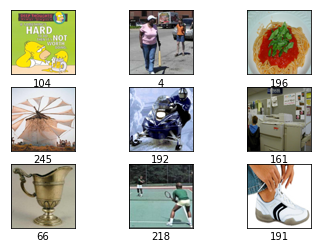

In [6]:
example_transform = transforms.Compose(
            [
                transforms.Scale((224,224)),
                transforms.ToTensor(),
            ]
        )

train_loader, validation_loader = get_train_valid_loader("/datasets/Caltech256/256_ObjectCategories/",
                       batch_size=32,
                       transform=example_transform,
                       show_sample=True)

test_loader = get_test_loader("/datasets/Caltech256/256_ObjectCategories/",
                             batch_size=32,
                             transform=example_transform)

In [22]:
def train(net, 
          epoch=100,
          learning_rate=0.001):
    '''
    param: net neural network
    param: opt optimizer type
    param: epoch 
    param: learning_rate
    param: p_batch print batch size
    '''
    net.cuda()
    criterion = nn.CrossEntropyLoss() 
    optimizer = optim.SGD(net.classifier._modules['6'].parameters(), lr=0.001, momentum=0.9)
    
    loss_train = []
    loss_validation = []
    percentage_train = []
    percentage_validation = []

    for p in range(epoch):  # loop over the dataset multiple times
        
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, labels = data
            
            labels = labels.long()
            
            labels = labels.view(train_loader.batch_size)
#             labels = labels.add(-1)
            
#             print(labels)
            # wrap them in Variable
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
#             print 1
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.data[0]
        
        print('epoch: %d' % (p+1))
        print('Train Loss: %.3f' % (running_loss/len(train_loader)))
        loss_train.append(running_loss/len(train_loader))
        loss_validation.append(compute_loss(net, validation_loader))
        percentage_train.append(percent_correct(net, train_loader, "train"))
        percentage_validation.append(percent_correct(net, validation_loader, "validation"))
        
    print('Finished Training')
    percent_correct(net, test_loader, "test")
    print('Test Loss %.3f' % (compute_loss(net, test_loader)))
    print('Finished Testing')
    print('Plot')
    
    plt.figure()
    plt.title('Loss')
    plt.plot(loss_train, label='loss_train')
    plt.plot(loss_validation, label='loss_validation')
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.title('Percent Correct')
    plt.plot(percentage_train, label='percent_train')
    plt.plot(percentage_validation, label='percent_validation')
    plt.legend()
    plt.show()

In [8]:
def percent_correct(net, loader, mode):
    correct = 0
    total = 0
    
    for data in loader:
        images, labels = data
        outputs = net(Variable(images.cuda()))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum()

    print('Accuracy of the network on the %d %s images: %.2f %%' % (total, mode, 100. * correct / total))
    return 100. * correct / total

In [9]:
def compute_loss(net, loader):
    criterion = nn.CrossEntropyLoss()
    running_loss = 0.0
    
    for data in loader:
        images, labels = data
        outputs = net(Variable(images.cuda()))
        loss = criterion(outputs, Variable(labels.cuda()))
        running_loss += loss.data[0]
    
    return running_loss/len(loader)

In [10]:
vgg16 = torchvision.models.vgg16(pretrained=True)

for param in vgg16.parameters():
    param.requires_grad = False

vgg16.classifier._modules['6'] = nn.Linear(4096, 256)

In [25]:
train(vgg16, epoch=10, learning_rate=0.0001)

RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1503966894950/work/torch/lib/THC/generic/THCTensorCopy.c:18